In [1]:
import random
import os
import h5py
import numpy as np
from work.dataset.activitynet import ActivityNetDataset

dataset = ActivityNetDataset(
    videos_path='../../../../../dataset/videos.json',
    labels_path='../../../../../dataset/labels.txt'
)
videos = dataset.get_subset_videos('validation')
videos = random.sample(videos, 8)

In [2]:
experiment = 3
nb_epoch = 150

#predictions_file = '../predictions/predictions_{experiment:02d}_e{nb_epoch:03d}.hdf5'.format(
#    experiment=experiment, nb_epoch=nb_epoch)
predictions_file = '../../lstm_activity_classification_feedback/predictions/predictions_{experiment:02d}_e{nb_epoch:03d}.hdf5'.format(
    experiment=experiment, nb_epoch=nb_epoch)
weights_path = '../model_snapshot/lstm_activity_classification_{experiment:02d}_e{nb_epoch:03d}.hdf5'
predictions_dataset = h5py.File(predictions_file, 'r')['validation']

predictions = []
for v in videos:
    prediction = predictions_dataset[v.video_id][...]
    class_prediction = np.argmax(prediction, axis=1)
    predictions.append((v, prediction, class_prediction))

Video ID: 9WhPG89P-tg		Ground truth: Getting a haircut
0.1083	Smoking hookah
0.0637	Arm wrestling
0.0314	Playing flauta


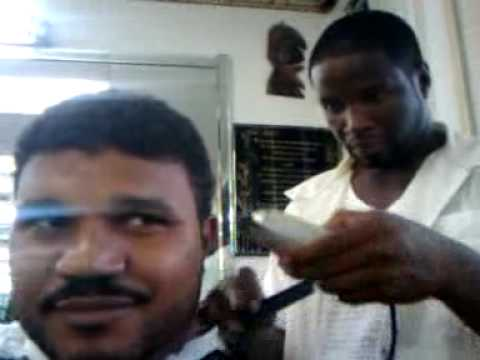



Video ID: nI_XzNfxjlY		Ground truth: Swimming
0.8296	Swimming
0.0100	Fixing the roof
0.0092	Canoeing


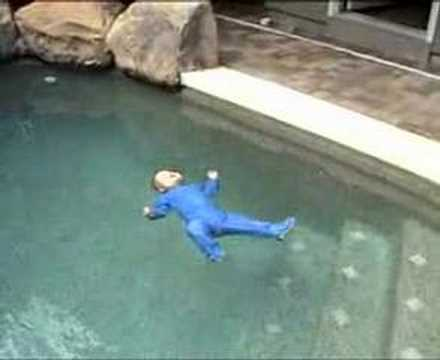



Video ID: 7JXae2so5-E		Ground truth: Welding
0.6055	Welding
0.0295	Sailing
0.0205	Brushing hair


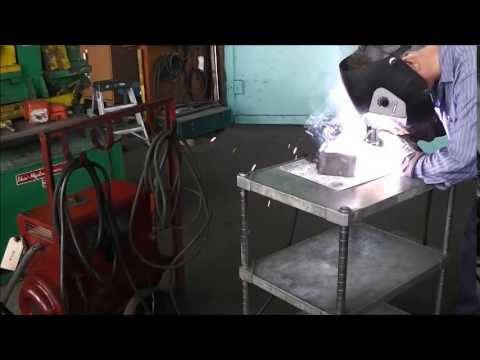



Video ID: RZogaNvPuNs		Ground truth: Making a lemonade
0.0585	Putting on makeup
0.0431	Peeling potatoes
0.0315	Smoking hookah


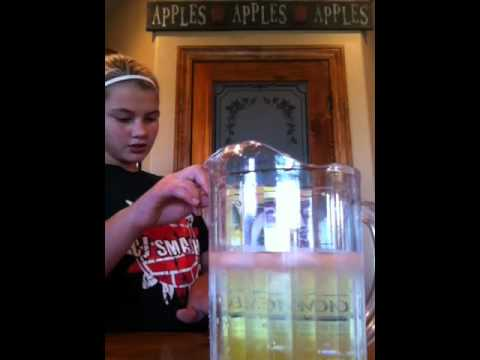



Video ID: 8nhuvbFSSmw		Ground truth: Longboarding
0.9766	Longboarding
0.0012	Skateboarding
0.0006	BMX


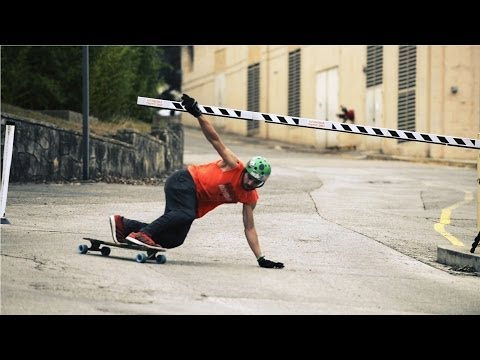



Video ID: hgLDMHCcw4k		Ground truth: Kneeling
0.8245	Ballet
0.0221	Tai chi
0.0138	Sharpening knives


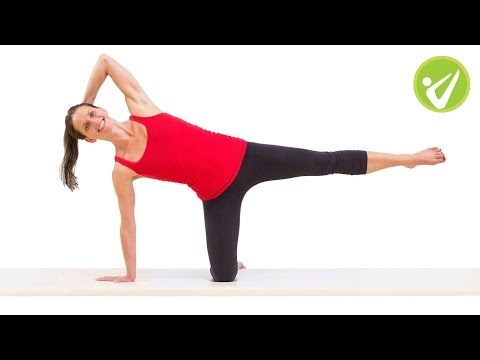



Video ID: OBb4013eIc8		Ground truth: Wakeboarding
0.1584	Welding
0.0675	Removing ice from car
0.0623	Snow tubing


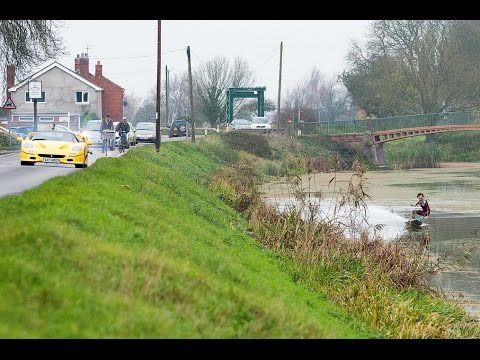



Video ID: 5asz3rt3QyQ		Ground truth: Building sandcastles
0.9157	Building sandcastles
0.0654	Playing beach volleyball
0.0096	Beach soccer


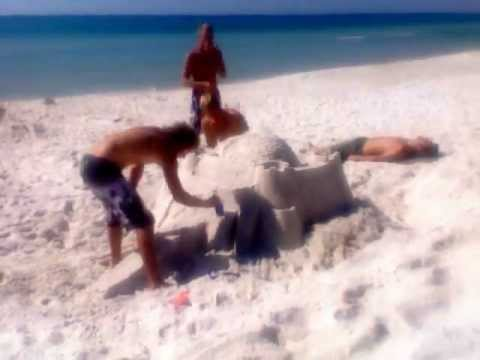

In [3]:
from IPython.display import YouTubeVideo, display

for v, prediction, class_prediction in predictions:
    print('Video ID: {}\t\tGround truth: {}'.format(v.video_id, v.get_activity()))
    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    vid = YouTubeVideo(v.video_id)
    display(vid)
    print('\n')

Video ID: 9WhPG89P-tg
Main Activity: Getting a haircut
0.1083	Smoking hookah
0.0637	Arm wrestling
0.0314	Playing flauta


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


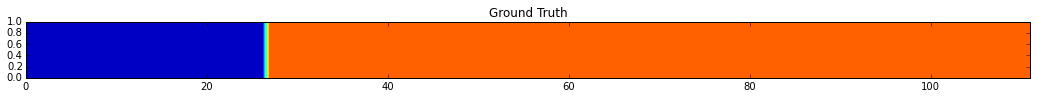

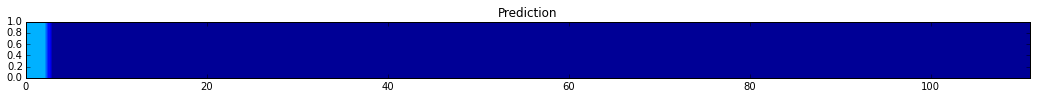

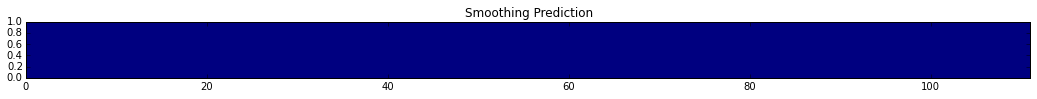



Video ID: nI_XzNfxjlY
Main Activity: Swimming
0.8296	Swimming
0.0100	Fixing the roof
0.0092	Canoeing


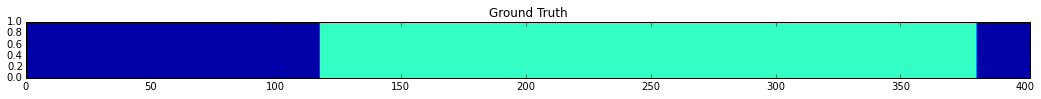

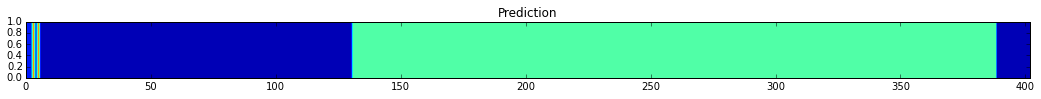

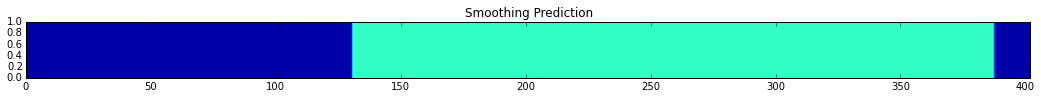



Video ID: 7JXae2so5-E
Main Activity: Welding
0.6055	Welding
0.0295	Sailing
0.0205	Brushing hair


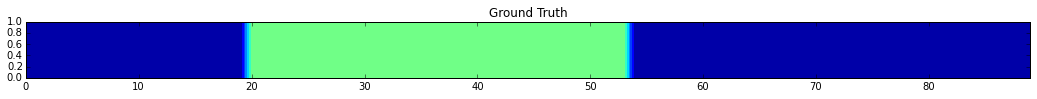

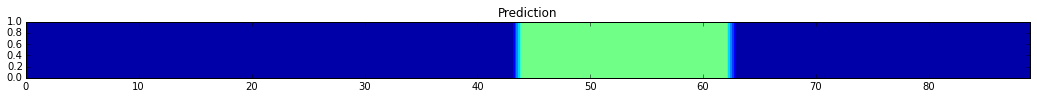

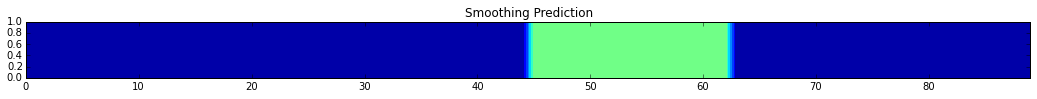



Video ID: RZogaNvPuNs
Main Activity: Making a lemonade
0.0585	Putting on makeup
0.0431	Peeling potatoes
0.0315	Smoking hookah


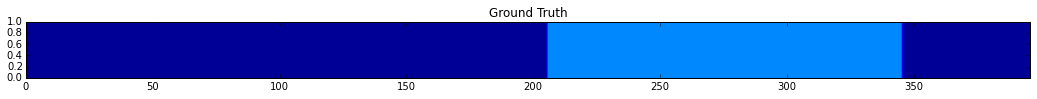

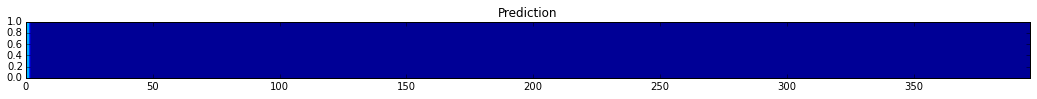

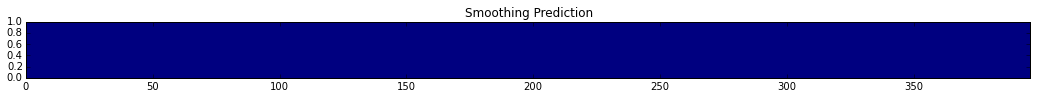



Video ID: 8nhuvbFSSmw
Main Activity: Longboarding
0.9766	Longboarding
0.0012	Skateboarding
0.0006	BMX


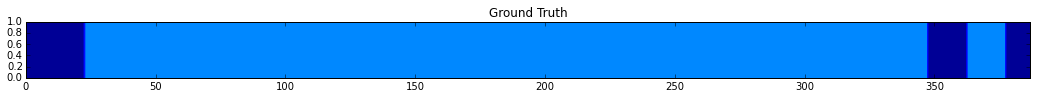

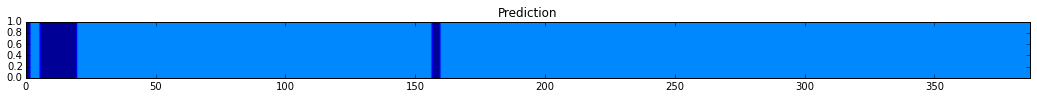

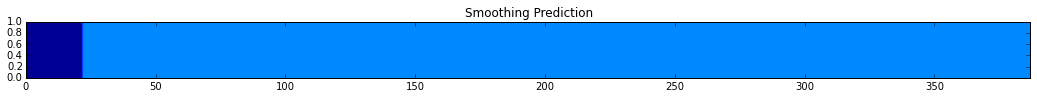



Video ID: hgLDMHCcw4k
Main Activity: Kneeling
0.8245	Ballet
0.0221	Tai chi
0.0138	Sharpening knives


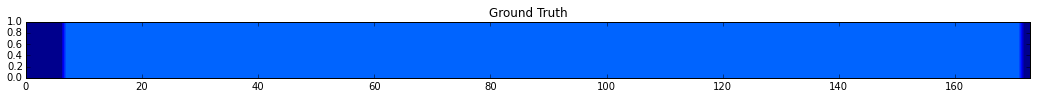

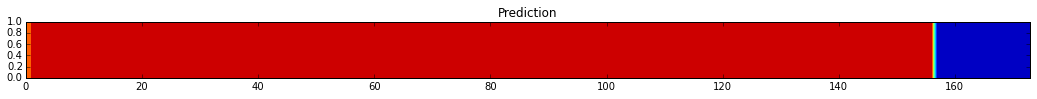

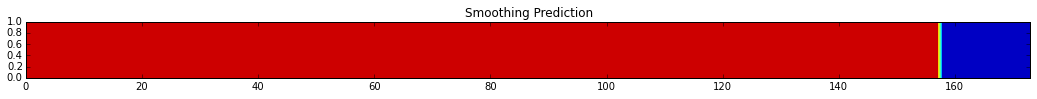



Video ID: OBb4013eIc8
Main Activity: Wakeboarding
0.1584	Welding
0.0675	Removing ice from car
0.0623	Snow tubing


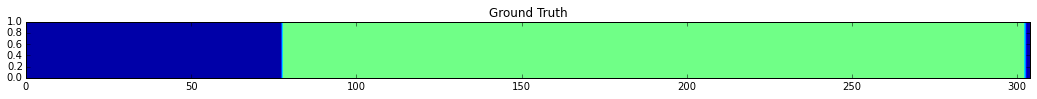

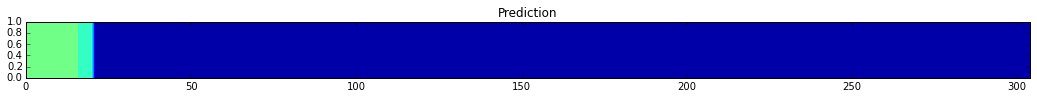

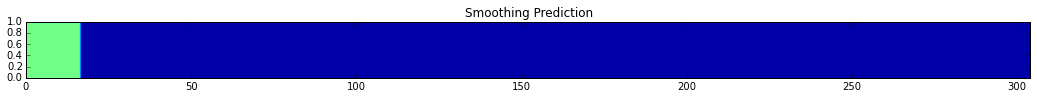



Video ID: 5asz3rt3QyQ
Main Activity: Building sandcastles
0.9157	Building sandcastles
0.0654	Playing beach volleyball
0.0096	Beach soccer


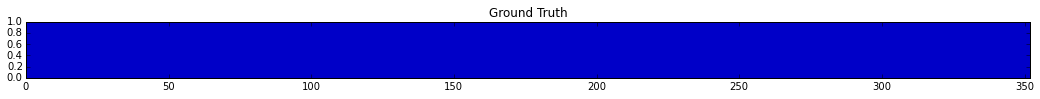

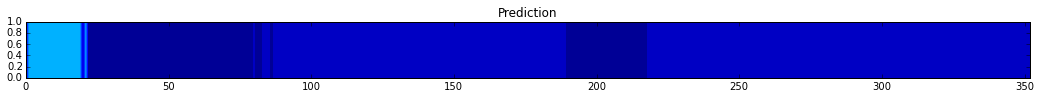

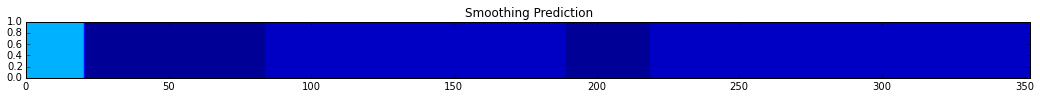

In [4]:
from work.processing.output import smoothing
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
normalize = matplotlib.colors.Normalize(vmin=0, vmax=201)
normalize_1 = matplotlib.colors.Normalize(vmin=0, vmax=1)

for v, prediction, class_prediction in predictions:
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))
    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))

    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(class_prediction, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(np.argmax(smoothing(prediction, k=10), axis=1), (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Smoothing Prediction')
    plt.show()

    print('\n')

In [5]:
from work.processing.output import get_top_k_predictions_score
import numpy as np

def get_temporal_predictions(prob, fps=1, clip_length=16., threshold=.2):
    classes = np.argmax(prob, axis=1)
    top_activity, scores = get_top_k_predictions_score(classes, k=1)

    activity_prob = 1 - prob[:,0]
    activity_tag = np.zeros(activity_prob.shape)
    activity_tag[activity_prob>=threshold] = 1

    assert activity_tag.ndim == 1
    padded = np.pad(activity_tag, pad_width=1, mode='constant')
    dif = padded[1:] - padded [:-1]

    indexes = np.arange(dif.size)
    startings = indexes[dif == 1]
    endings = indexes[dif == -1]

    assert startings.size == endings.size

    results = []
    if not top_activity:
        return results
    for s, e in zip(startings, endings):
        results.append({
            #'score': scores[0],
            'score': np.mean(prob[s:e,top_activity[0]]),
            'segment': [
                s * clip_length / fps,
                e * clip_length / fps
            ],
            'label': top_activity[0]
        })

    return results

def get_temporal_prediction_argmax(prob, fps=1, clip_length=16., threshold=.3):
    classes = np.argmax(prob, axis=1)
    top_activity, scores = get_top_k_predictions_score(classes, k=1)
    results = []
    if not top_activity:
        return results
    
    activity_tag = np.zeros(classes.shape)
    activity_tag[prob[:,top_activity[0]]>threshold] = 1
    
    assert activity_tag.ndim == 1
    padded = np.pad(activity_tag, pad_width=1, mode='constant')
    dif = padded[1:] - padded [:-1]

    indexes = np.arange(dif.size)
    startings = indexes[dif == 1]
    endings = indexes[dif == -1]

    assert startings.size == endings.size

    for s, e in zip(startings, endings):
        results.append({
            #'score': scores[0],
            'score': np.mean(prob[s:e,top_activity[0]]),
            'segment': [
                s * clip_length / fps,
                e * clip_length / fps
            ],
            'label': top_activity[0]
        })

    return results


In [11]:
import json
import sys

import h5py
from progressbar import ProgressBar

from work.dataset.activitynet import ActivityNetDataset
from work.processing.output import smoothing

predictions_path = '../predictions/predictions_09_e100.hdf5'
#predictions_path = '../../lstm_activity_classification_feedback/predictions/predictions_02_e100.hdf5'

dataset = ActivityNetDataset(
    videos_path='../../../../../dataset/videos.json',
    labels_path='../../../../../dataset/labels.txt'
)

f_predictions = h5py.File(predictions_path, 'r')
subset = 'testing'
print('Generating results for {} subset...'.format(subset))
subset_predictions = f_predictions[subset]

progbar = ProgressBar(max_value=len(subset_predictions.keys()))
with open('../../../evaluation/data/result_template_{}.json'.format(subset), 'r') as f:
    results = json.load(f)

count = 0
progbar.update(0)
for video in dataset.get_subset_videos(subset):
    if video.video_id not in subset_predictions.keys():
        continue
    prediction = subset_predictions[video.video_id]
    #class_predictions = np.argmax(prediction, axis=1)
    prediction_smoothed = smoothing(prediction, k=5)
    temporal_predictions = get_temporal_predictions(prediction_smoothed, fps=video.fps, threshold=.2)
    #temporal_predictions = get_temporal_prediction_argmax(prediction_smoothed, fps=video.fps)
    for p in temporal_predictions:
        label = dataset.labels[p['label']][1]
        p['label'] = label

    results['results'][video.video_id] = temporal_predictions
    count += 1
    progbar.update(count)

progbar.finish()
with open('prediction.json', 'w') as f:
    json.dump(results, f)

f_predictions.close()


Generating results for testing subset...


100% (4980 of 4980) |######################| Elapsed Time: 0:04:41 Time: 0:04:41


In [9]:
from work.evaluation.detection import ANETdetection

ground_truth_filename = '../../../evaluation/data/activity_net.v1-3.min.json'
anet_detection = ANETdetection(ground_truth_filename, 'prediction.json',
                                   subset='validation', tiou_thr=.5,
                                   verbose=True, check_status=True)
anet_detection.evaluate()

[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 7502
	Number of predictions: 6239
	Fixed threshold for tiou score: 0.5
[RESULTS] Performance on ActivityNet detection task.
	Mean Average Precision: 0.136876149569


# Results Table

Table for classification model

smooth | `k=1` | `k=5` | `k=10` | `k=20`
------: | :-----: | :----: | :------: | :----:
**threshold** | | | |
**`.20`** | | `0.225138` | `0.221362` | `0.213753`
**`.30`** | | `0.220776` | `0.221001` | `0.216062`
**`.50`** | `0.203217` | | `0.213029` | 

Table for classification model with feedback with `k=10` and threshold `.2`: 



In [ ]:
no_results = [v for v in results['results'].keys() if len(results['results'][v]) == 0]

In [ ]:
len(no_results)

In [ ]:
no_results

In [ ]:
f_predictions = h5py.File(predictions_path, 'r')
pred = f_predictions['validation'][no_results[0]][...]
f_predictions.close()

In [ ]:
print(pred[:,0])

In [ ]:
plt.plot(pred[:,0])

In [ ]:
plt.plot(np.argmax(pred, axis=1))